In [2]:
import pandas as pd
from rdkit import Chem
import seaborn as sns
from tqdm import tqdm
import numpy as np

In [3]:
tqdm.pandas()


# Carbon-Mangels CYP2D6

Original data source is https://onlinelibrary.wiley.com/doi/10.1002/minf.201100069

Curated by TDC @ https://tdcommons.ai/single_pred_tasks/adme#cyp2d6-substrate-carbon-mangels-et-al

We will pull directly from TDC, with the description on TDC given below

"""

Dataset Description: CYP2D6 is primarily expressed in the liver. It is also highly expressed in areas of the central nervous system, including the substantia nigra. TDC used a dataset from [1], which merged information on substrates and nonsubstrates from six publications.

"""

## Assay info

Merge of several other papers





In [4]:
from tdc.single_pred import ADME
data = ADME(name = 'CYP2D6_Substrate_CarbonMangels')


Found local copy...
Loading...
Done!


In [5]:
df = data.get_data()
df.head()

,Drug_ID,Drug,Y
0,abacavir,Nc1nc(NC2CC2)c2ncn([C@H]3C=C[C@@H](CO)C3)c2n1,0
1,abecarnil,COCc1c(C(=O)OC(C)C)ncc2[nH]c3ccc(OCc4ccccc4)cc...,0
2,abiraterone,C[C@]12CC[C@H]3[C@@H](CC=C4C[C@@H](O)CC[C@@]43...,0
3,acebutolol,CCCC(=O)Nc1ccc(OC[C@@H](O)CNC(C)C)c(C(C)=O)c1,0
4,aceclofenac,O=C(O)COC(=O)Cc1ccccc1Nc1c(Cl)cccc1Cl,0


<Axes: xlabel='Y', ylabel='count'>

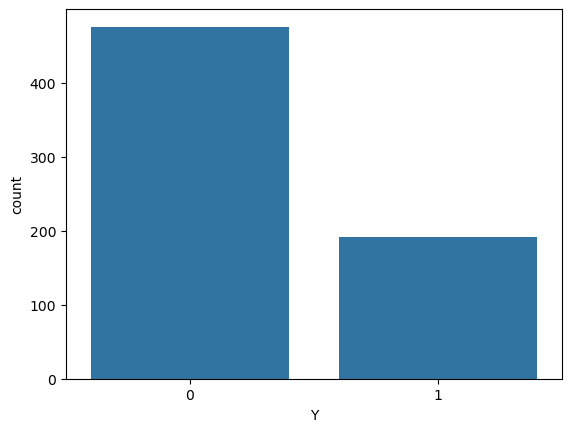

In [6]:
sns.countplot(data=df, x="Y")

In [7]:
# lets do a bit of renaming
df.rename(columns={"Drug": "SMILES", "Y":"Active", "Drug_ID":"common_name"}, inplace=True)

In [8]:
df

,common_name,SMILES,Active
0,abacavir,Nc1nc(NC2CC2)c2ncn([C@H]3C=C[C@@H](CO)C3)c2n1,0
1,abecarnil,COCc1c(C(=O)OC(C)C)ncc2[nH]c3ccc(OCc4ccccc4)cc...,0
2,abiraterone,C[C@]12CC[C@H]3[C@@H](CC=C4C[C@@H](O)CC[C@@]43...,0
3,acebutolol,CCCC(=O)Nc1ccc(OC[C@@H](O)CNC(C)C)c(C(C)=O)c1,0
4,aceclofenac,O=C(O)COC(=O)Cc1ccccc1Nc1c(Cl)cccc1Cl,0
...,...,...,...
662,zolpidem,Cc1ccc(-c2nc3ccc(C)cn3c2CC(=O)N(C)C)cc1,1
663,zonisamide,NS(=O)(=O)Cc1noc2ccccc12,0
664,zopiclone,CN1CCN(C(=O)O[C@H]2c3nccnc3C(=O)N2c2ccc(Cl)cn2...,0
665,zotepine,CN(C)CCOC1=Cc2ccccc2Sc2ccc(Cl)cc21,1


In [9]:
import mols2grid

In [10]:
mols2grid.display(df)

MolGridWidget()

In [21]:
active = df.query("Active == 1")
df["active"] = df["Active"] == 1
df.drop(columns="Active", inplace=True)

In [22]:
mols2grid.display(active)

MolGridWidget()

In [23]:
# standardisation of SMILES
from rdkit import Chem
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit.rdBase import BlockLogs
import mols2grid

In [24]:

# from Pat Walters method
def standardize_smiles(smiles):
    try:
        # follows the steps in
        # https://github.com/greglandrum/RSC_OpenScience_Standardization_202104/blob/main/MolStandardize%20pieces.ipynb
        # as described **excellently** (by Greg) in
        # https://www.youtube.com/watch?v=eWTApNX8dJQ
        mol = Chem.MolFromSmiles(smiles)
    
        # removeHs, disconnect metal atoms, normalize the molecule, reionize the molecule
        clean_mol = rdMolStandardize.Cleanup(mol)
    
        # if many fragments, get the "parent" (the actual mol we are interested in) 
        parent_clean_mol = rdMolStandardize.FragmentParent(clean_mol)
    
        # try to neutralize molecule
        uncharger = rdMolStandardize.Uncharger()  # annoying, but necessary as no convenience method exists
        uncharged_parent_clean_mol = uncharger.uncharge(parent_clean_mol)
    
        # note that no attempt is made at reionization at this step
        # nor at ionization at some pH (rdkit has no pKa caculator)
        # the main aim to represent all molecules from different sources
        # in a (single) standard way, for use in ML, catalogue, etc.
    
        te = rdMolStandardize.TautomerEnumerator()  # idem
        taut_uncharged_parent_clean_mol = te.Canonicalize(uncharged_parent_clean_mol)
    
        return Chem.MolToSmiles(taut_uncharged_parent_clean_mol)
    except:
        return pd.NA

In [25]:

with BlockLogs():
    df["CANONICAL_SMILES"] = df["SMILES"].progress_apply(lambda x: standardize_smiles(x))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 667/667 [00:05<00:00, 115.95it/s]


In [26]:
def smi_to_inchikey(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        return Chem.MolToInchiKey(mol)
    except:
        return pd.NA

In [27]:
# compute inchikeys
with BlockLogs():
    df["INCHIKEY"] = df["CANONICAL_SMILES"].progress_apply(lambda x: smi_to_inchikey(x))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 667/667 [00:00<00:00, 4081.50it/s]


In [28]:
df.INCHIKEY.isna().sum() # everything worked

np.int64(0)

In [29]:
df.head()

,common_name,SMILES,CANONICAL_SMILES,INCHIKEY,active
0,abacavir,Nc1nc(NC2CC2)c2ncn([C@H]3C=C[C@@H](CO)C3)c2n1,Nc1nc(NC2CC2)c2ncn([C@H]3C=C[C@@H](CO)C3)c2n1,MCGSCOLBFJQGHM-SCZZXKLOSA-N,False
1,abecarnil,COCc1c(C(=O)OC(C)C)ncc2[nH]c3ccc(OCc4ccccc4)cc...,COCc1c(C(=O)OC(C)C)ncc2[nH]c3ccc(OCc4ccccc4)cc...,RLFKILXOLJVUNF-UHFFFAOYSA-N,False
2,abiraterone,C[C@]12CC[C@H]3[C@@H](CC=C4C[C@@H](O)CC[C@@]43...,C[C@]12CC[C@H](O)CC1=CC[C@@H]1[C@@H]2CC[C@]2(C...,GZOSMCIZMLWJML-VJLLXTKPSA-N,False
3,acebutolol,CCCC(=O)Nc1ccc(OC[C@@H](O)CNC(C)C)c(C(C)=O)c1,CCCC(=O)Nc1ccc(OC[C@@H](O)CNC(C)C)c(C(C)=O)c1,GOEMGAFJFRBGGG-HNNXBMFYSA-N,False
4,aceclofenac,O=C(O)COC(=O)Cc1ccccc1Nc1c(Cl)cccc1Cl,O=C(O)COC(=O)Cc1ccccc1Nc1c(Cl)cccc1Cl,MNIPYSSQXLZQLJ-UHFFFAOYSA-N,False


In [30]:
# not much more to do really
df["dataset"] = "carbon-mangels_2011"
df["data_type"] = "assay" # going to assume assay
df["action_type"] = "substrate"

In [31]:
df.to_csv("processed/carbon-mangels_2011.csv", index=False)